## This python code generates a spatial 2D random field given mean velocity value, correlation of variation (by which standard deviation can be calculated), length scale in X (horizontal) and Z (vertical) directions, correlation function, length of the domain and element size for stochastic mesh. The last two parameters will be replaced by FEM mesh once implemented into SeismoSSI.

In [20]:
import matplotlib.pylab as plt
import numpy as np

#### This cell fixs the seed, defined initial parameters needed to do the simulation.

In [21]:
np.random.seed(40) # setting Random Seed number

dx=1 #  Spatial distance
dz=dx #  Spatial distance
ax=10 # Horizontal lengthscale, correlation length
az=2 # Vertical lengthscale, correlation length
nu=0 # Hurst exponent
ix=100 # size of model in same scale as ax
iz=100 # size of model in same scale as az

autocorrelation_type = 'vonkarman' # type of autocorrelation function 1) gaussian 2) exponential 3) vonkarman

vs_mean = 220 # mean background velocity
COV = 0.2 # coefficient of variation
vs_std = COV * vs_mean # standard deviation of stochastic velocity field

#### This cell creates the stochastic mesh which will be replaced by FEM mesh once it's available.

In [22]:
nx=int(np.ceil(ix/dx))
nz=int(np.ceil(iz/dz))


if (nx/2)!=np.round(nx/2):
    ddx=1 
    nx=nx+ddx
else:
    ddx=0
if (nz/2) != np.round(nz/2):
    ddz=1
    nz=nz+ddz 
else:
    ddz=0

In [23]:
# random_data = np.random.rand(nx,nz)-0.5 # initial pdf generated by uniform distribution 
random_data = np.random.normal(0, 1, (nx,nz)) # initial pdf generated by normal distribution 
# Any other distribution can be used here
random_data_transformed = np.fft.fftshift(np.fft.fft2(random_data)) # transforming to wavenumber domain

x=np.arange(0,nx)*dx
z=np.arange(0,nz)*dz
dkx=1/(nx*dx);
dkz=1/(nz*dz);
[kx,kz]=np.meshgrid(2*np.pi*dkx*np.arange(-nx/2,nx/2),2*np.pi*dkz*np.arange(-nz/2,nz/2), indexing='ij')

k=np.sqrt(kx**2*ax**2+kz**2*az**2) # wavenumber matrix 

#### This cell defines the Power Spectral Density (PSD) of the correlation functions and their fourier transform. The PSD functions are obtained from Mai & Beroza (2002). 

In [24]:
if autocorrelation_type == 'gaussian':
    auto_correl=((ax*az)/2)*np.exp(-(k**2/4)) # PSD of autocorrelation function
    auto_correl=np.sqrt(auto_correl)  # PSD to Fourier transform, Fourier transform is square root of PSD

if autocorrelation_type == 'exponential':
    auto_correl=(ax*az)/(1+k**2)**1.5
    auto_correl=np.sqrt(auto_correl)  


if autocorrelation_type == 'vonkarman':
    auto_correl=(ax*az)/(1+k**2)**(nu+1)
    auto_correl=np.sqrt(auto_correl)  

#### This cell creates the spatial random field in wavenumber domain and transforms it back to spatial domain

In [25]:
convolved_data=random_data_transformed*auto_correl
data_transformed_back = np.real(np.fft.ifftshift(np.fft.ifft2(convolved_data)))
data_transformed_back = vs_mean + data_transformed_back*vs_std

##### Image of initial pdf

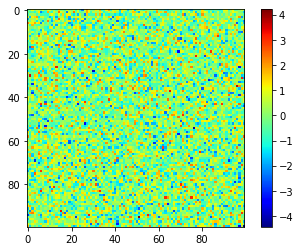

In [26]:
fig, ax = plt.subplots()
im = ax.imshow(np.transpose(random_data), cmap='jet')
fig.colorbar(im, orientation='vertical')
plt.show()

##### Image of correlation function

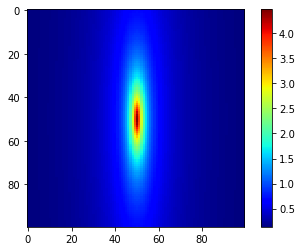

In [27]:
fig, ax = plt.subplots()
im = ax.imshow(np.transpose(auto_correl), cmap='jet')
fig.colorbar(im, orientation='vertical')
plt.show()

##### Image of final spatial random field

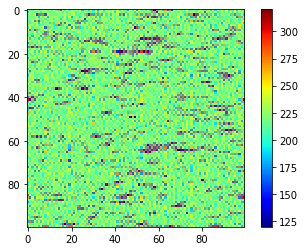

In [28]:
fig, ax = plt.subplots()
im_1 = ax.imshow(np.transpose(data_transformed_back), cmap='jet')
fig.colorbar(im_1, orientation='vertical')
plt.show()